<br>


<p style="font-size:32px; text-align:center"> <b>Comparison of Base Transformer and Custom Transformer</b></p>



In [26]:
import math
import os
from tempfile import TemporaryDirectory
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset
import matplotlib.pyplot as plt

## Creating Custom Encoder layer for our Custom Transformer
##### (Achieved this encoder architechture by many hit and trial processes)
<p style="font-size:16px"> 1. We created a new experimental encoder layer. <br><br> 2. We introduced <b>two parallel multihead self-attention layers in the encoder with half the number of heads</b> in the base transformer model <b>to ensure the number of self attention heads remain same</b>.<br><br>3. Also We introduced <b>GELU activation function in place of ReLU activation</b >function in the final feedforward network.<br><br>4. Talking about it, we <b>increased the number of layers in the feedforward net by one</b> with <b>middle one and starting one equal to half the number of neurons in base transformer model.</b> <br><br> 5. We didnt change layer normalisation and created our custom encoder layer that would make our custom transformer.<br><br>6. We <b>added dropout of 0.6</b> in the final feedforward net to reduce total parameters . <b><br><br></b></p>

## LETS SEE IF IT ACHIEVES SAME ACCURACY AS BASE VARIANT

In [27]:
class CustomTransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.5):
        super(CustomTransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead // 2)
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward//2),
            nn.GELU(),
            nn.Dropout(0.6),
            nn.Linear(dim_feedforward//2, dim_feedforward//2),
            nn.GELU(),
            nn.Dropout(0.6),
            nn.Linear(dim_feedforward//2, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.norm4 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, src_mask, is_causal = False, src_key_padding_mask = None):
        # Self-attention layer
        attn_output_1, _ = self.self_attn(x, x, x,attn_mask = src_mask, 
                                          key_padding_mask = src_key_padding_mask, 
                                          is_causal = is_causal)
        x_1 = x + self.dropout(attn_output_1)
        x_1 = self.norm1(x_1)
        
        attn_output_2, _ = self.self_attn(x, x, x,attn_mask = src_mask, 
                                          key_padding_mask = src_key_padding_mask, 
                                          is_causal = is_causal)
        x_2 = x + self.dropout(attn_output_2)
        x_2 = self.norm2(x_2)
        
        x_tot = x_1 + x_2

        # Feedforward layer
        ff_output = self.feedforward(x_tot)
        x_tot = x_tot + self.dropout(ff_output)
        x_tot = self.norm4(x_tot)

        return x_tot

## Define the base transformer model

In [28]:
class TransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

## Define the Custom transformer model

In [29]:
class CustomTransformerModel(nn.Module):

    def __init__(self, ntoken: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'CustomTransformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = CustomTransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.embedding = nn.Embedding(ntoken, d_model)
        self.d_model = d_model
        self.linear = nn.Linear(d_model, ntoken)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: Tensor, src_mask: Tensor = None) -> Tensor:
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        if src_mask is None:
            src_mask = nn.Transformer.generate_square_subsequent_mask(len(src)).to(device)
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

## Defining Positional Encoding

In [30]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## Load and batch data




In [31]:
from torchtext.datasets import WikiText2
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

train_iter = WikiText2(split='train')
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

def data_process(raw_text_iter: dataset.IterableDataset) -> Tensor:
    """Converts raw text into a flat Tensor."""
    data = [torch.tensor(vocab(tokenizer(item)), dtype=torch.long) for item in raw_text_iter]
    return torch.cat(tuple(filter(lambda t: t.numel() > 0, data)))

train_iter, val_iter, test_iter = WikiText2()
train_data = data_process(train_iter)
val_data = data_process(val_iter)
test_data = data_process(test_iter)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def batchify(data: Tensor, bsz: int) -> Tensor:
    seq_len = data.size(0) // bsz
    data = data[:seq_len * bsz]
    data = data.view(bsz, seq_len).t().contiguous()
    return data.to(device)

batch_size = 20
eval_batch_size = 10
train_data = batchify(train_data, batch_size)  
val_data = batchify(val_data, eval_batch_size)
test_data = batchify(test_data, eval_batch_size)

## Functions to generate input and target sequence




In [32]:
bptt = 35
def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    seq_len = min(bptt, len(source) - 1 - i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target

## Initiate both Base Tansformer Model and Custom Transformer Model




In [33]:
ntokens = len(vocab)  
emsize = 200  
d_hid = 1028  
nlayers = 4  
nhead = 8  
dropout_1 = 0.2  
dropout_2 = 0.25
model_1 = TransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout_1).to(device)
model_2 = CustomTransformerModel(ntokens, emsize, nhead, d_hid, nlayers, dropout_2).to(device)

## Training and Evaluation Functons




In [34]:
import time
def train(model: nn.Module) -> float:
    criterion = nn.CrossEntropyLoss()
    lr = 1.0  
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
    model.train()  
    total_loss = 0.
    log_interval = 200
    start_time = time.time()

    num_batches = len(train_data) // bptt
    for batch, i in enumerate(range(0, train_data.size(0) - 1, bptt)):
        data, targets = get_batch(train_data, i)
        output = model(data)
        output_flat = output.view(-1, ntokens)
        loss = criterion(output_flat, targets)
        

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()

        total_loss += loss.item()

    return total_loss/num_batches

def evaluate(model: nn.Module, eval_data: Tensor) -> float:
    model.eval()  
    total_loss = 0.
    with torch.no_grad():
        for i in range(0, eval_data.size(0) - 1, bptt):
            criterion = nn.CrossEntropyLoss()
            data, targets = get_batch(eval_data, i)
            seq_len = data.size(0)
            output = model(data)
            output_flat = output.view(-1, ntokens)
            total_loss += seq_len * criterion(output_flat, targets).item()
    return total_loss / (len(eval_data) - 1)

## MODEL TRAINING



TRAINING MODEL 1
-----------------------------------------------------------------------------------------------
| end of epoch   1 | time: 79.12s | train loss  6.37 | valid loss  5.84 | valid ppl   343.07
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   2 | time: 79.64s | train loss  5.77 | valid loss  5.57 | valid ppl   263.25
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   3 | time: 79.02s | train loss  5.51 | valid loss  5.42 | valid ppl   225.77
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   4 | time: 77.75

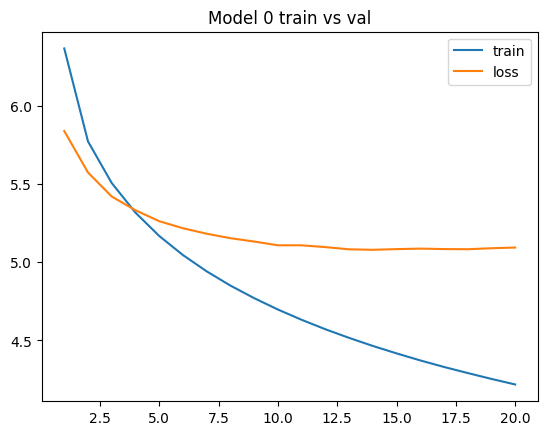

TRAINING MODEL 2
-----------------------------------------------------------------------------------------------
| end of epoch   1 | time: 94.92s | train loss  6.40 | valid loss  5.87 | valid ppl   352.78
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   2 | time: 100.89s | train loss  5.80 | valid loss  5.61 | valid ppl   274.22
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   3 | time: 98.35s | train loss  5.54 | valid loss  5.47 | valid ppl   236.33
-----------------------------------------------------------------------------------------------
-----------------------------------------------------------------------------------------------
| end of epoch   4 | time: 94.4

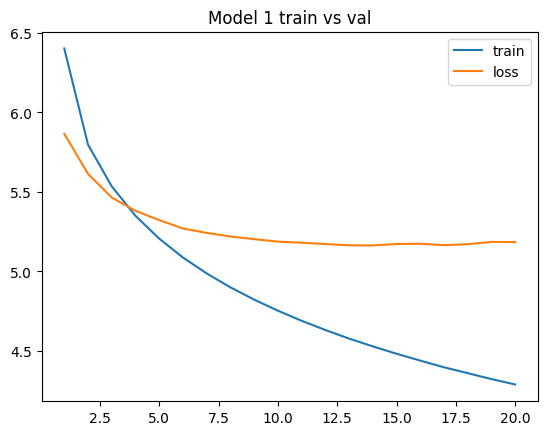

In [35]:
best_val_loss = float('inf')
epochs = 20

with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
    
    for i, model in enumerate([model_1, model_2]):
        print('TRAINING MODEL {}'.format(i+1))
        train_arr = []
        val_arr = []
        ep_arr = []
        for epoch in range(1, epochs + 1):
            epoch_start_time = time.time()
            train_loss = train(model)
            val_loss = evaluate(model, val_data)
            train_arr.append(train_loss)
            val_arr.append(val_loss)
            ep_arr.append(epoch)
            val_ppl = math.exp(val_loss)
            elapsed = time.time() - epoch_start_time
            print('-' * 95)
            print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | train loss {train_loss:5.2f} | '
                f'valid loss {val_loss:5.2f} | valid ppl {val_ppl:8.2f}')
            print('-' * 95)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), best_model_params_path)
        plt.title(f'Model {i} train vs val')
        plt.plot(ep_arr, train_arr)
        plt.plot(ep_arr, val_arr)
        plt.legend(['train', 'loss'])
        plt.savefig(f'model {i}.png', dpi=300)
        plt.show()


## Evaluate the base Transformer model on the test dataset

In [36]:
test_loss = evaluate(model_1, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.01 | test ppl   150.11


## Evaluate the Custom Transformer model on the test dataset

In [37]:
test_loss = evaluate(model_2, test_data)
test_ppl = math.exp(test_loss)
print('=' * 89)
print(f'| End of training | test loss {test_loss:5.2f} | '
      f'test ppl {test_ppl:8.2f}')
print('=' * 89)

| End of training | test loss  5.11 | test ppl   165.83


## Conclusion
<p style="font-size:16px"> We can observe multiple finding from this activity:-<br><br>1. During Training, our <b>Custom Transformer Model behaves exactly like Base Transformer model</b> in terms of <code>training_loss vs epochs</code> and <code>val_loss vs epochs plot</code>. This tells us that our <b>Custom Transformer model do not violate Transformer model algorithm</b> and works like it only.<br><br>2. We can observe that the Custom Transformer model <b>receives just slighltly higher training and validaion loss</b> in comparision to the base transformer model. This tells us that <b>our current custom transformer model definition is not upto the mark to that of pre defined Transformers.</b><br><br><br></p>
<p style="font-size:18px; text-align:center"> <b> THROUGH THIS STUDY WE PROPOSED A NEW TRANSFORMER ENCODER ARCHITECHTURE THAT ACHIEVED SIMILAR PERFORMANCE LEVELS TO THAT OF VANILLA TANSFORMER AND PROVIDES US WITH A VALID ALTERNATIVE TO THE CURRENT ARCHITECHTURE. </b></p>